In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import copy

In [2]:
#alpha-quasi-GNEP
#linearized coupled inverted pendulum

In [3]:
#linearized continuous system
# theta_1, theta_1',x_1,x_1', theta_2,theta_2', x_2,x_2'
g_a=9.81 #gravity
k_sp=1 #spring constante
d=3   #length of relaxed spring
l=1    #length

A=np.array([[0,1,0,0,       0,0,0,0],
            [g_a/l,0,k_sp/l,0,    0,0,-k_sp/l,0],
            [0,0,0,1,       0,0,0,0],
            [0,0,-k_sp,0,      0,0,k_sp,0],
            [0,0,0,0,       0,1,0,0],
            [0,0,-k_sp/l,0,       g_a/l,0,k_sp/l,0],
            [0,0,0,0,       0,0,0,1],
            [0,0,k_sp,0,       0,0,-k_sp,0]])
B=np.array([[0,0],
           [-1/l,0],
           [0,0],
           [1,0],
           [0,0],
           [0,-1/l],
           [0,0],
           [0,1]])


nx=8 #dimension of state
nu=2 #dimension of control (in total)
Nu=2 #amount of players
sampling_rate=0.1

In [4]:
x_ast=np.array([0.0,0.0,0,0.0, 0.0,0.0,d,0.0]) #stationary state
N=20                                           #look-ahead horizon

In [5]:
#discretize system via RK4
steps = 1
dt = sampling_rate/steps

C= -A@x_ast

A_k1 = A
B_k1 = B
C_k1= C
            
A_k2 = A + A@A_k1*(dt/2)
B_k2 = A@B_k1*(dt/2) + B
C_k2=A@C_k1*(dt/2)+C
            
A_k3 = A + A @ A_k2*(dt/2)
B_k3 = A@B_k2*(dt/2) + B
C_k3=A@C_k2*(dt/2)+C
            
A_k4 = A + A @ A_k3 * dt
B_k4 = A@B_k3*dt + B
C_k4=A@C_k3*(dt)+C
            
A_rk4 = (A_k1 + A_k2*2 + A_k3*2 + A_k4)*(dt/6)
B_rk4 = (B_k1 + B_k2*2 + B_k3*2 + B_k4)*(dt/6)
C_rk4 = (C_k1 + C_k2*2 + C_k3*2 + C_k4)*(dt/6)


A_cont=A
B_cont=B
C_cont=C
A = np.eye(nx)   
B= np.zeros((nx,nu))
C=np.zeros(C.shape)
for i in range(steps):
    C = C+ A@C_rk4
    B = B+ A@B_rk4
    A = A+ A@A_rk4 

In [6]:
#nonlinear dynamics
def f(x,u):
    th1=x[1]
    th2=x[5]
    x1=x[3]
    x2=x[7]
    
    dth1=(g_a/l)*np.sin(x[0])-(1/l)*np.cos(x[0])*(u[0]+k_sp*(x[6])-x[2]-d)
    dth2=(g_a/l)*np.sin(x[4])-(1/l)*np.cos(x[4])*(u[1]+k_sp*(x[2])-x[6]+d)
    dx1=u[0]+k_sp*(x[6]-x[2]-d)
    dx2=u[1]+k_sp*(x[2]-x[6]+d)
    return np.array([th1,dth1,x1,dx1, th2,dth2, x2, dx2 ])

def f_RK4(x,u):
    k1=dt*f(x,u)
    k2=dt*f(x+(1/2)*k1,u)
    k3=dt*f(x+(1/2)*k2,u)
    k4=dt*f(x+k3,u)
    return x+(1/6)*(k1+2*k2+2*k3+k4)

def f_real(x,u):
    rearange=[0,4,  1,5, 2,6,  3,7 ]
    u=u[rearange]
    for i in range(4):
        x=f_RK4(x,u[i*2:i*2+2])
    return x

In [7]:
#parameters
alpha=0.1  #alpha-pertubation
beta=0.    #regularization of Nikaido-Isoda
gamma=1    #penealty control
b=100      #bounds

In [8]:
from scipy.optimize import Bounds
bounds = Bounds((N)*nu*[-b], (N)*nu*[b])

In [9]:
def endcond(u,x_iv):
    u=u.reshape((N,nu))
    x=x_iv
    for k in range(N):
        x=A@x+B@u[k] +C
    return x-x_ast

In [10]:
nx_p=nx//Nu
nu_p=nu//Nu
def ell(x,u,i):
    res=0.5*np.dot(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p],x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
    res+=gamma*0.5*np.dot(u[i*nu_p:i*nu_p+nu_p],u[i*nu_p:i*nu_p+nu_p])
    return res

In [11]:
def inner_objective(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
   #input u in form (N,nu)
    su=0
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p] 
        for k in range(N):
            su+= ell(x,contrl[k],i)
            x=A@x+B@contrl[k]+C     
    diff=u-v
    su+=beta*0.5*np.dot(diff.flatten(),diff.flatten())              
    return su

In [12]:
K=[matrix_power(A,k)@B for k in range(N)]
def inner_objective_jac(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
    jac=np.zeros((N,nu))
    for i in range(Nu):
        x=x_iv
        control=copy.deepcopy(u)
        control[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        for k in range(N):
            diff=x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p]
            for n in range(0,k):
                tmp=diff@K[k-n-1][i*nx_p:i*nx_p+nx_p,i*nu_p:nu_p+i*nu_p]
                jac[n,i*nu_p:nu_p+i*nu_p]+=tmp.flatten()
            if k <N:
                x=A@x+B@control[k]+C     
        jac[0:N,i*nu_p:nu_p+i*nu_p]+=gamma*v[0:N,i*nu_p:nu_p+i*nu_p]
    jac+=beta*(v-u)    
    return jac.reshape(-1)

In [13]:
def g(x_iv,u):
    obj= lambda v: inner_objective(u,x_iv,v)
    jac= lambda v: inner_objective_jac(u,x_iv,v)
    v_0=np.zeros(u.shape).flatten()
    
    solution=minimize(obj,v_0, method="L-BFGS-B", jac=jac,bounds=bounds)
    if not solution.success:
        print("inner",solution.message)
    return solution

In [14]:
def objective(x_iv,u):
    u=u.reshape((N,nu)) 
    sec=0
    sec=(1-alpha)*g(x_iv,u).fun
    
    first=0
    x=x_iv
    for k in range(N):
        for i in range(Nu):
            first+=ell(x,u[k],i)       
        x=A@x+B@u[k]+C 
    return first-sec

In [15]:
K=[matrix_power(A,k)@B for k in range(N)]
def objective_jac(x_iv,u):  #only with respect to u
    u=u.reshape((N,nu))
    jac=np.zeros((N,nu))

    #part dependent on u only
    contrl=copy.deepcopy(u)
    x=copy.deepcopy(x_iv)
    for k in range(N):
        diff=(x-x_ast).transpose()
        for n in range(0,k):
            jac[n,:]+=diff@K[k-n-1]
        if k <N:
            x=A@x+B@contrl[k]+C 
    jac+=gamma*u
    #second part
    v=g(x_iv,u).x
    v=v.reshape((N,nu))
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        j=1-i
        for n in range(N):
            diff=(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
            for k in range(0,n):
                tmp=diff@K[n-k-1][i*nx_p:i*nx_p+nx_p,j*nu_p:nu_p+j*nu_p]
                jac[k,j*nu_p:nu_p+j*nu_p]+=-(1-alpha)*tmp
            if n<N:
                x=A@x+B@contrl[n]+C
    jac+=beta*(v-u)            
    return jac.reshape(-1)

In [16]:
def addnoise(x,a):
    return x+np.random.uniform(low=-a,high=a, size=x.size)
def addnoise_fac(x,b):
    y=x
    for i in range(len(x)):
        y[i]=x[i]+np.random.uniform(low=-b*np.abs(x[i]),high=b*np.abs(x[i]))
    return y

In [31]:
maxIter=100                             #max. iteration
x_ivv=np.asarray([np.pi,0,0,0,0,0,d,0]) #inital value
noise=0.01                              #noise
op={"maxiter":1e3}                      #optimization parameter

In [32]:
x_iv=x_ivv
u_0=np.zeros(N*nu)
u_star=[]          #control
x_star=[]          #state
V=[]               #Lyapunov function
x_Last=[]          #state at lookahead horizon
x_end=[]           #endcondition
x_star.append(x_iv)
for i in range(maxIter):
    if i%10==0:
        print(i)
    obj= lambda u: objective(x_iv,u)
    jac= lambda u: objective_jac(x_iv,u)
    ec= lambda u: endcond(u,x_iv)
    end_cond={'type': "eq",'fun': ec}
    solution=minimize(obj,u_0,method="SLSQP", jac=jac,bounds=bounds, constraints=end_cond)
    if not solution.success:
        print(i, solution.message, endcond(solution.x, x_iv))
    contrl=solution.x
    contrl=contrl.reshape((N,nu))
    x_last=x_iv
    for k in range(N):
        x_last=A@x_last +B@contrl[k]+C
    x_Last.append(x_last)   
    x_end.append(endcond(solution.x, x_iv))   
    
    V.append(solution.fun)
    print(solution.fun)
    u_curr=solution.x.reshape((N,nu))[0]
    u_star.append(u_curr)
 
    x_iv=A@x_iv+B@u_curr+C
    x_iv=addnoise_fac(x_iv, noise)
 
    x_star.append(x_iv)

0
19371.711500463247
14307.007922906716
8366.840143094243
5040.400866766911
2959.9725581426524
1785.579514087693
1147.9639897028856
794.30857629754
592.9075599208272
480.264552099272
10
401.2725485466618
331.5277024138202
262.2048090882049
219.88772688204494
166.35824458802574
112.63959815531126
81.1022524368978
59.21172826262659
35.94565326135347
22.350367785783078
20
14.07576832674701
8.371236506317338
5.234687581064691
3.4815113156403097
2.454951739567493
1.7059033615323211
1.333165585752499
1.1488666908373983
0.9059183007579901
0.76668179939298
30
0.6563864405607753
0.4908168766545087
0.42332839821111845
0.19718820652436697
0.1457665602435444
0.09847677461340248
0.1037315697628953
0.04628893528818109
0.04997452038455706
0.04193502234714951
40
0.04374719042710463
0.039346443001344
0.05286083328868073
0.18290440996475796
0.016847900340658556
0.037795823810245606
0.11363647163272197
0.18471213121660252
0.12947296193072422
0.16187734732748266
50
0.2611931883672685
0.13638937941602144
0

In [33]:
import os
dictname="CIP/alpha/"
os.makedirs(dictname)

FileExistsError: [Errno 17] File exists: 'CIP/alpha/'

In [34]:
with open(dictname+"/stats.txt", "w") as file:
    file.write("alpha="+str(alpha))
    file.write("\n")
    file.write("inital value="+str(x_ivv))
    file.write("\n")
    file.write("N="+str(N))
    file.write("\n")
    file.write("noise="+str(noise))
    file.write("\n")
    file.write("U=["+str(-b)+","+str(b)+"]")
    file.write("\n")
    file.write("gamma="+str(gamma))
    file.write("\n")
    file.write("beta="+str(beta))
    file.write("\n")
    file.write("spring="+str(k_sp))
    file.write("\n")
    file.write("rod_length="+str(l))

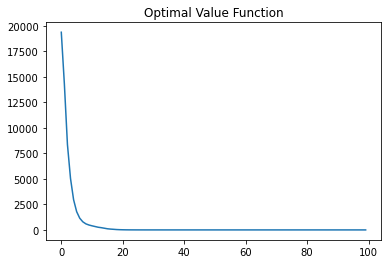

In [35]:
plt.plot(V)
plt.title('Optimal Value Function')
plt.savefig("./"+dictname+"/optimalvalue.png")

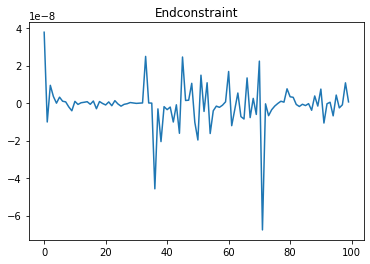

In [36]:
X_Last=[x-x_ast for x in x_Last]
X_Last=np.asarray(X_Last)
Xend=np.asarray(x_end)
plt.plot(np.sum(X_Last, axis=1))
plt.title("Endconstraint")
plt.savefig("./"+dictname+"/endcond.png")

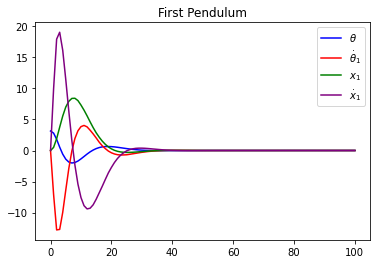

In [37]:
X_star=np.asarray(x_star)

plt.plot(X_star[:,0],"blue", label=r"$\theta$")
plt.plot(X_star[:,1],"red", label=r"$\dot{\theta}_1$")
plt.plot(X_star[:,2],"green", label=r"$x_1$")
plt.plot(X_star[:,3],"purple",label=r"$\dot{x}_1$")
plt.legend()
plt.title("First Pendulum")
plt.savefig("./"+dictname+"/pendlum1.png")

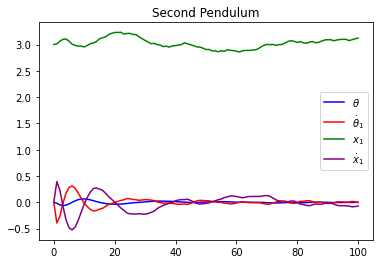

In [38]:
X_star=np.asarray(x_star)

plt.plot(X_star[:,4],"blue", label=r"$\theta$")
plt.plot(X_star[:,5],"red", label=r"$\dot{\theta}_1$")
plt.plot(X_star[:,6],"green", label=r"$x_1$")
plt.plot(X_star[:,7],"purple",label=r"$\dot{x}_1$")
plt.legend()
plt.title("Second Pendulum")
plt.savefig("./"+dictname+"/pendlum2.png")

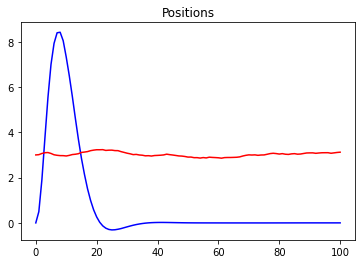

In [39]:
plt.plot(X_star[:,2],"blue")
plt.plot(X_star[:,6],"red")
plt.title('Positions')
plt.savefig("./"+dictname+"/positions.png")

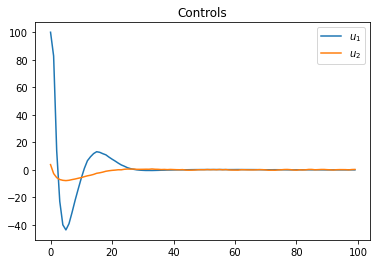

In [40]:
U_star=np.asarray(u_star)
plt.plot(U_star[:,0], label=r"$u_1$")
plt.plot(U_star[:,1],label=r"$u_2$")
plt.legend()
plt.title('Controls')
plt.savefig("./"+dictname+"/controls.png")